<a href="https://colab.research.google.com/github/halldm2000/NOAA-AI-2020-TUTORIAL/blob/master/curve_fitting_sea_ice_train_only.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Curve Fitting with PyTorch


**Download Data**

In [1]:
source = "ftp://sidads.colorado.edu/DATASETS/NOAA/G02135/north/daily/data/N_seaice_extent_daily_v3.0.csv"
dest    = "/content/data/"
!wget  -c -e robots=off -P {dest} {source}

--2020-10-21 16:39:22--  ftp://sidads.colorado.edu/DATASETS/NOAA/G02135/north/daily/data/N_seaice_extent_daily_v3.0.csv
           => ‘/content/data/N_seaice_extent_daily_v3.0.csv’
Resolving sidads.colorado.edu (sidads.colorado.edu)... 128.138.135.20
Connecting to sidads.colorado.edu (sidads.colorado.edu)|128.138.135.20|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /DATASETS/NOAA/G02135/north/daily/data ... done.
==> SIZE N_seaice_extent_daily_v3.0.csv ... 1556411
File has already been retrieved.
2020-10-21 16:39:22 (0.00 B/s) - ‘/content/data/N_seaice_extent_daily_v3.0.csv’ saved [1556411]



**Data Loading Routine**


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from datetime import datetime, timedelta

# make directory to store images
!mkdir -p images

def load_data():
    global xscaler, yscaler, X,Y,T

    # read sea-ice extent data from CSV file
    csv    = "/content/data/N_seaice_extent_daily_v3.0.csv"
    data   = np.loadtxt(csv, skiprows=2, delimiter=',', usecols=(0,1,2,3,4))
    extent = data[:,3]
    year   = data[:,0]
    nrows  = data.shape[0]

    # get day of the year
    yday   = np.zeros_like(year) 
    for i in range(nrows):
      yr, month, day = data[i,0:3].astype(int)
      yday[i] = datetime(yr,month,day).timetuple().tm_yday

    # put each variable in column format
    X = np.reshape(yday,  (-1,1))
    Y = np.reshape(extent,(-1,1))
    T = np.reshape(year,  (-1,1))

    # scale data to fit in the range -1,1
    xscaler = StandardScaler()
    yscaler = StandardScaler()
    x = torch.from_numpy(xscaler.fit_transform(X))
    y = torch.from_numpy(yscaler.fit_transform(Y))

    return x,y



**Plotting Routine**

In [3]:
def plot(interval = 1):

  global X,Y

  # exit if it's not time to plot
  if epoch%interval != 0: return

  # plot observations
  plt.figure(figsize=(10,7.5),dpi=72*1.25)
  plt.scatter(X,Y,c=T,alpha=0.2, s=5)
  plt.ylim(Y.min(), Y.max())

  # plot curve-fit
  Ypred = yscaler.inverse_transform(prediction)
  plt.scatter(X,Ypred,c='black',s=5);

  # print equation
  terms = [f"${w[i]:+.2f} X^{i} $" for i in range(len(w))]
  eqn   = "y ="+ ''.join(terms)+ f"     $X = (x - {x0[0]:.3f})$"
  plt.text(0.5, 1.02, eqn, transform=plt.gca().transAxes, fontsize=10, horizontalalignment='center')

  # set title, axis labels
  plt.xlabel("day of the year", fontsize=12)
  plt.ylabel("million sq km ", fontsize=12);
  plt.title(f"Annual Artic Sea-ice Extent   Epoch={epoch}   Training loss={loss.item():.3f} \n",fontsize=14)

  # save figure to file
  plt.savefig(f'./images/img_{epoch//interval:04d}',bbox_inches='tight');
  plt.show()

**Train the Model**

We have fit a 3rd order Taylor series to the data. Can we do better?

**<font color="red">TODO:</font>**
* Try changing the order of the model to N=2, N=5, etc
* Add more epochs if neccessary to get a better fit
* Adjust the learning rate (lr=...) 
* Try replacing MSELoss with L1Loss
* Increase plotting interval to reduce training time

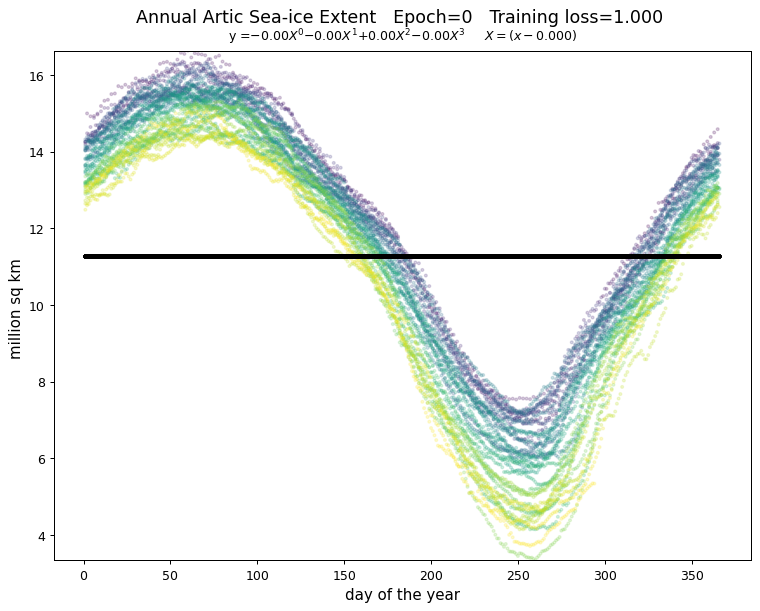

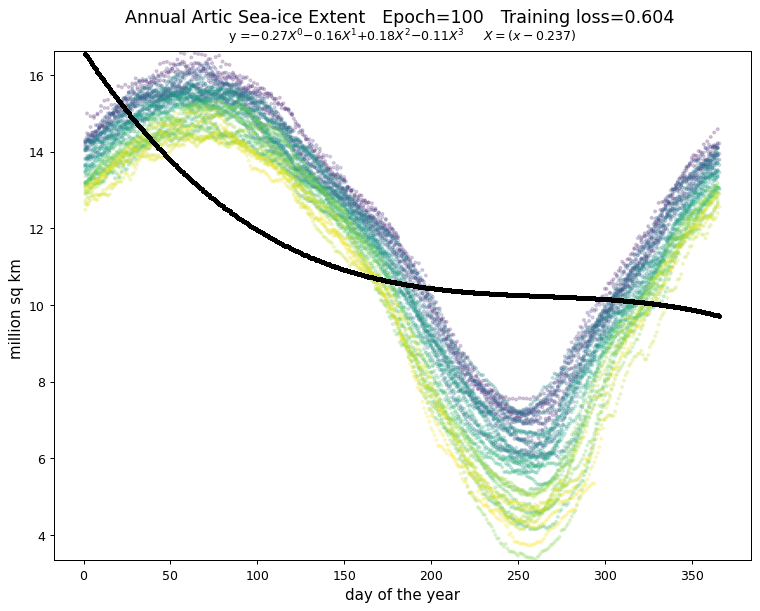

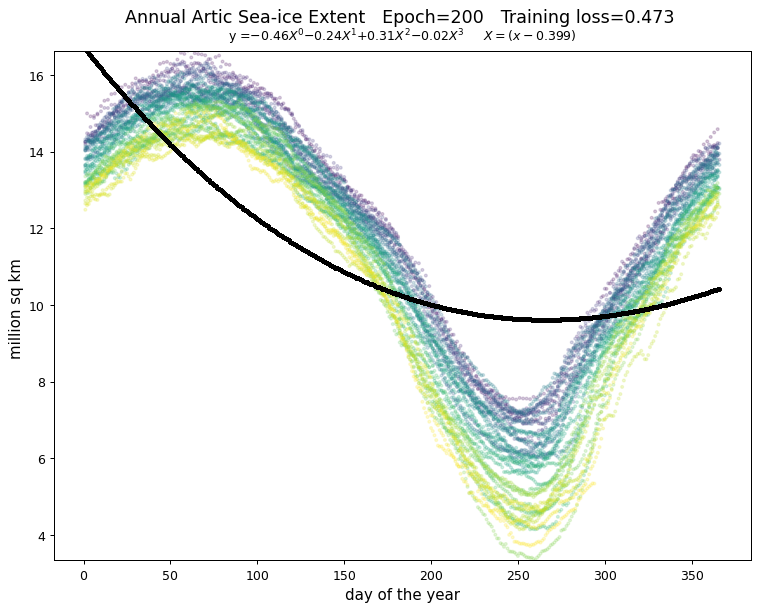

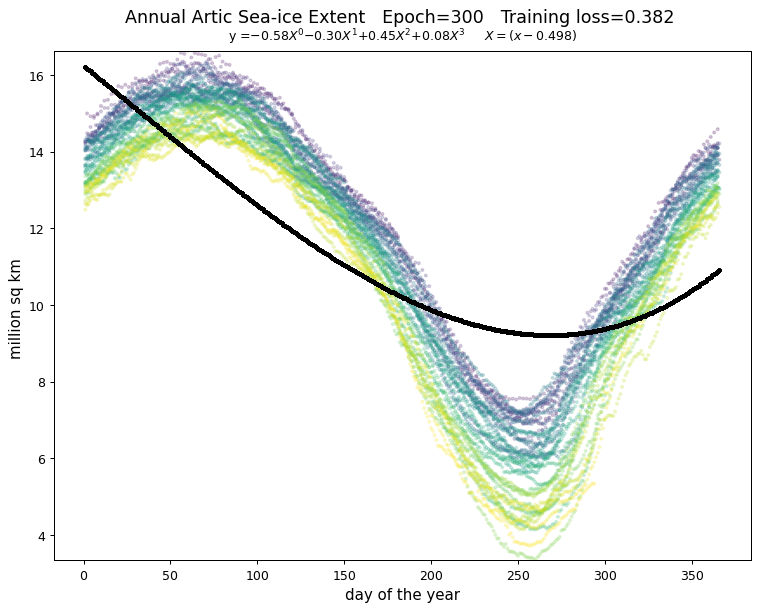

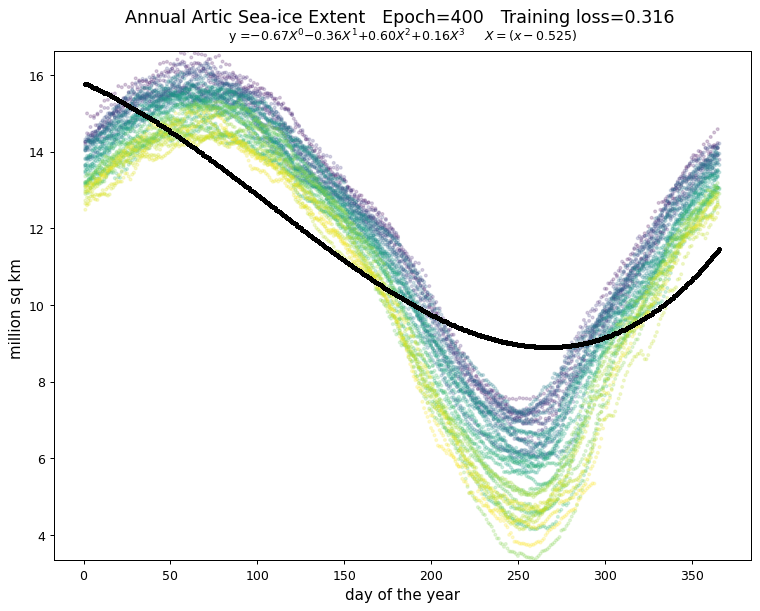

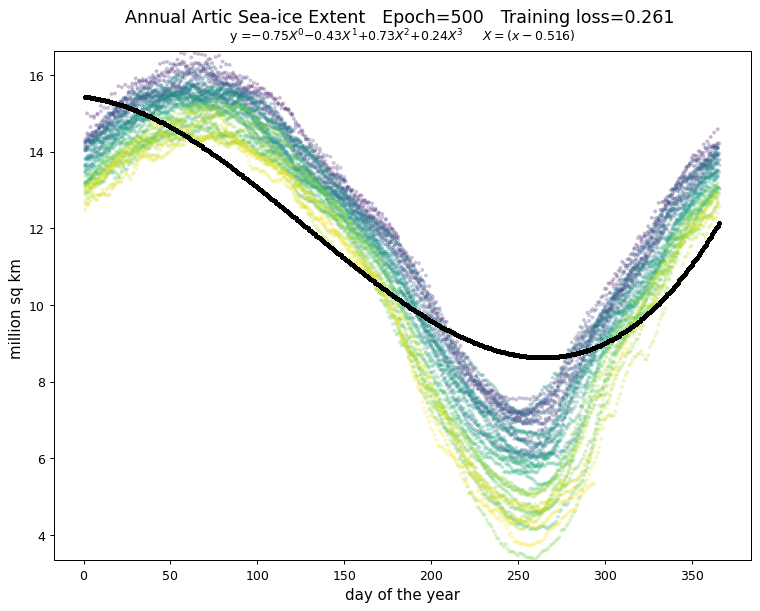

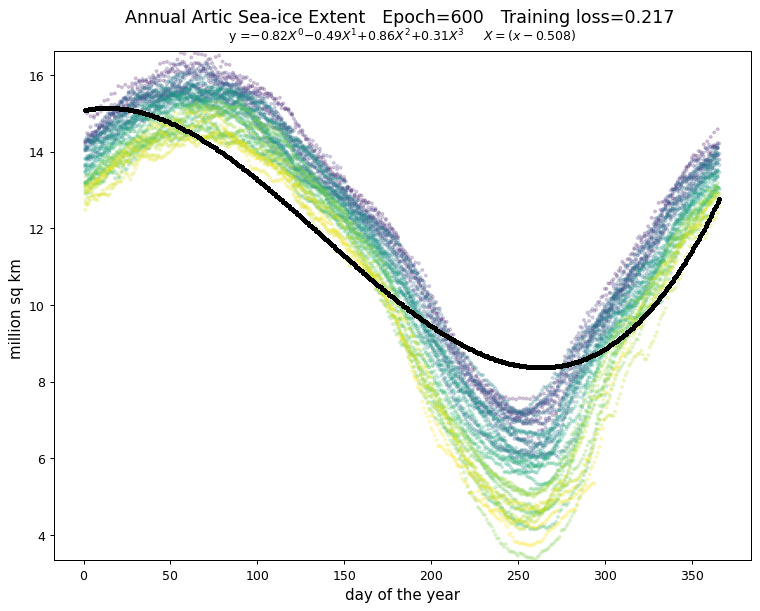

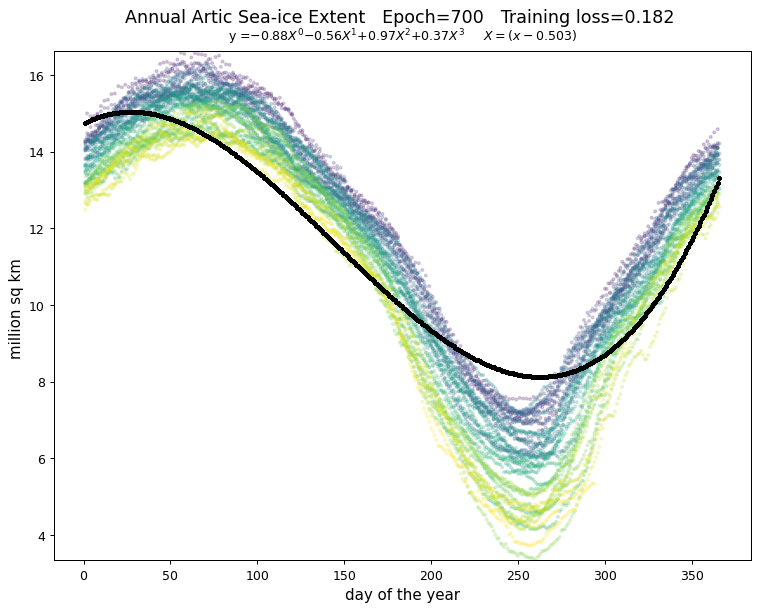

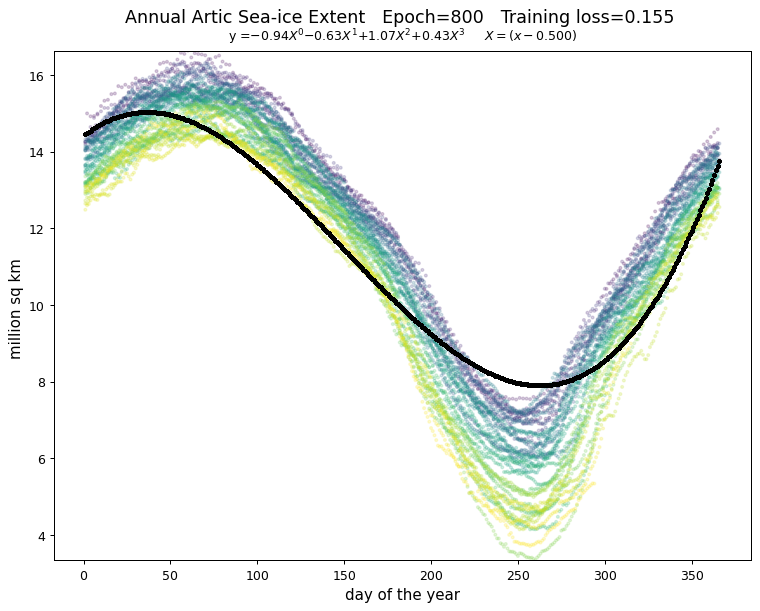

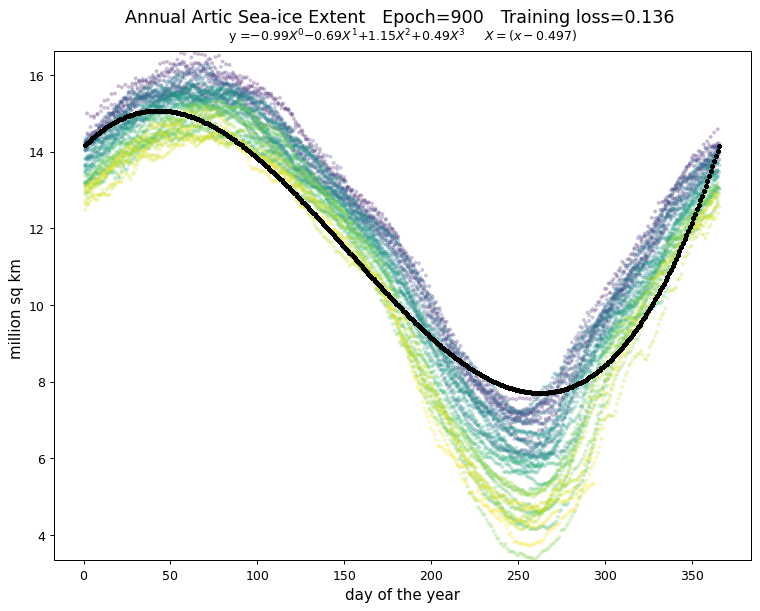

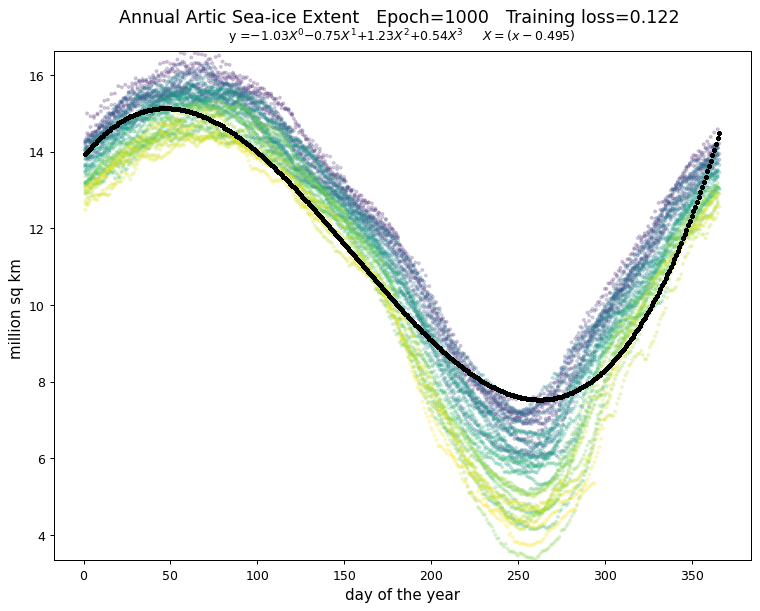

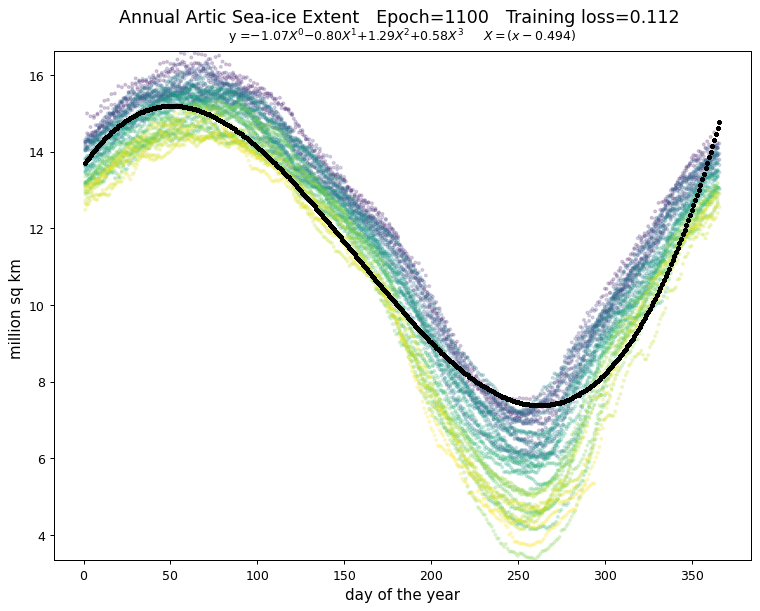

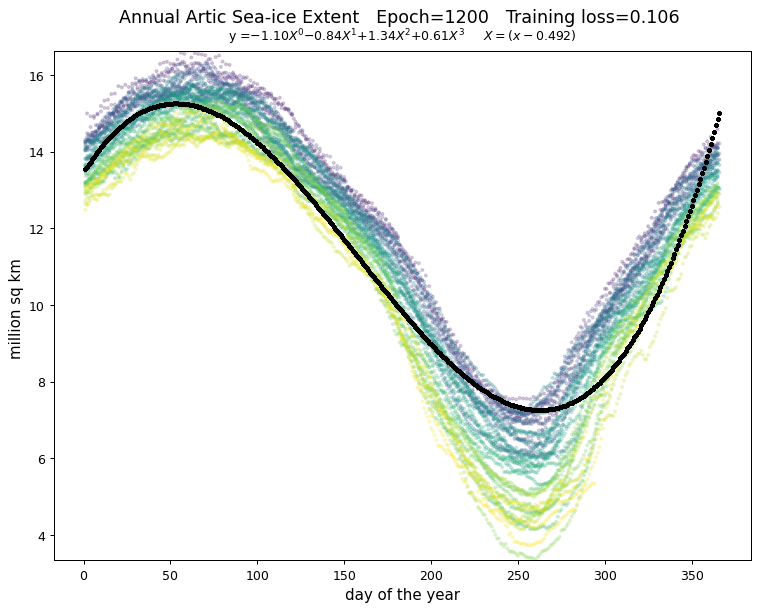

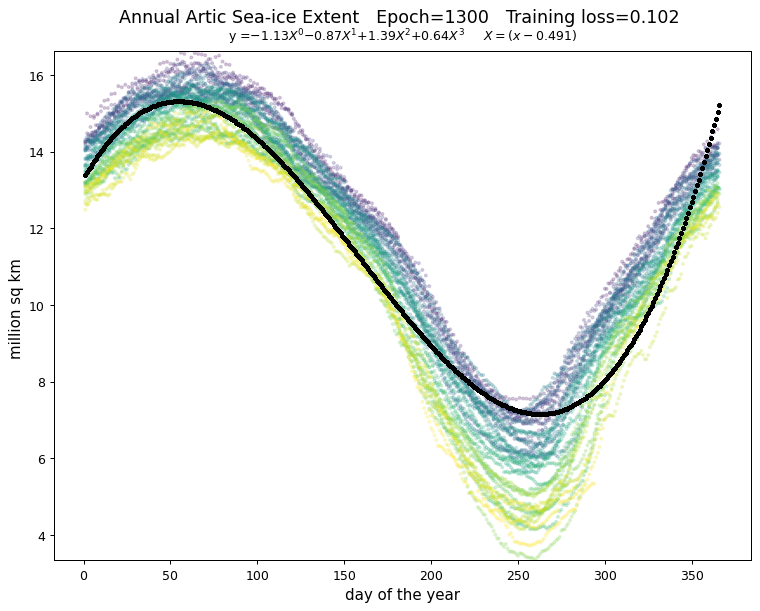

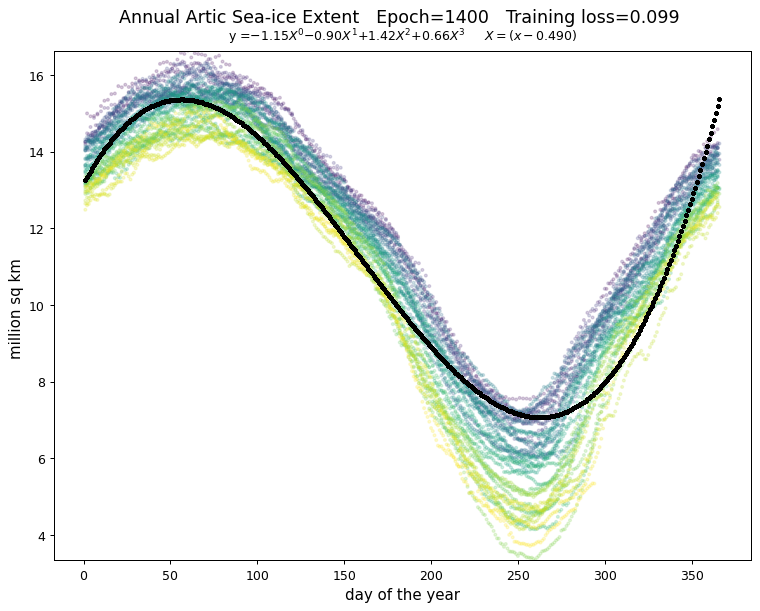

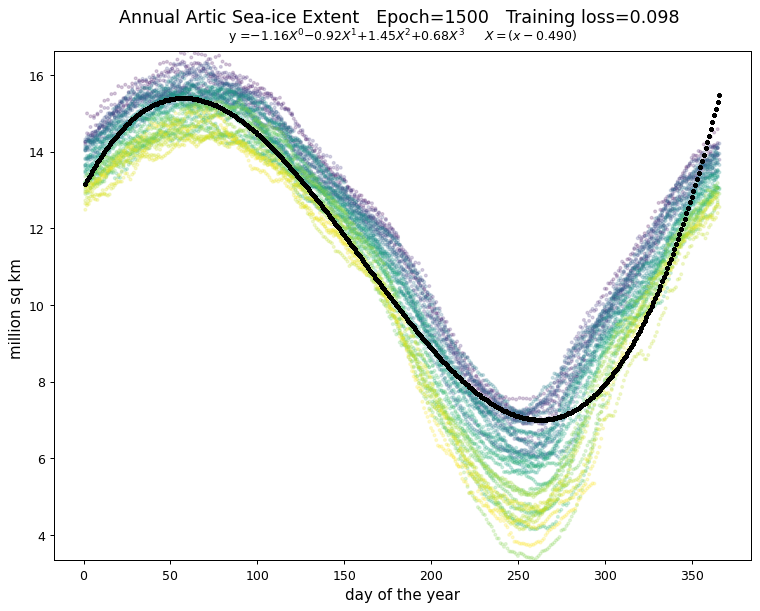

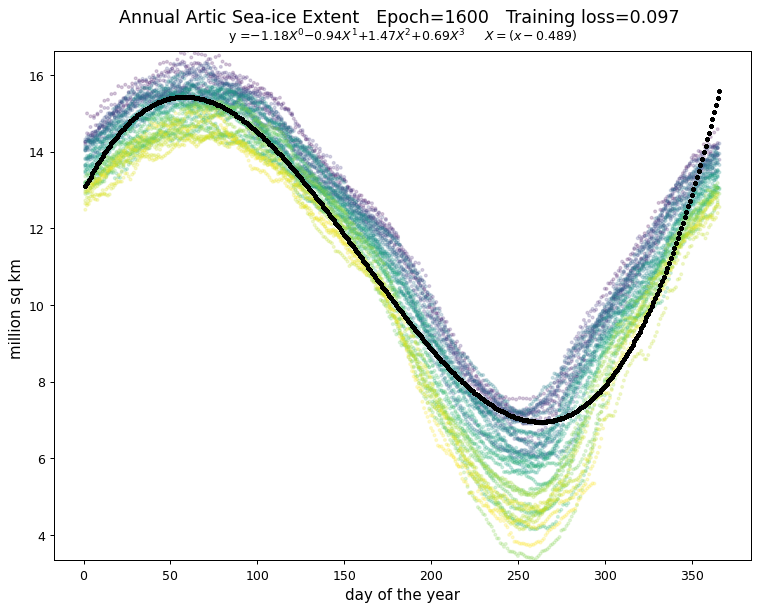

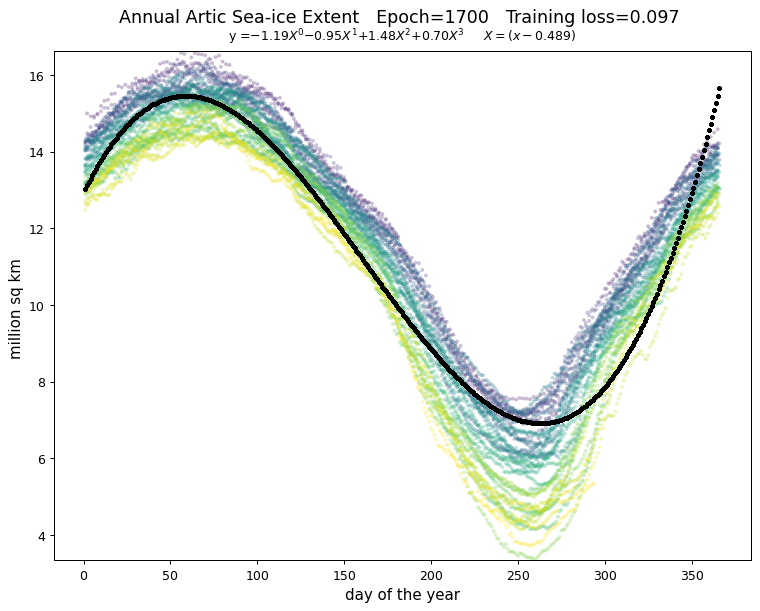

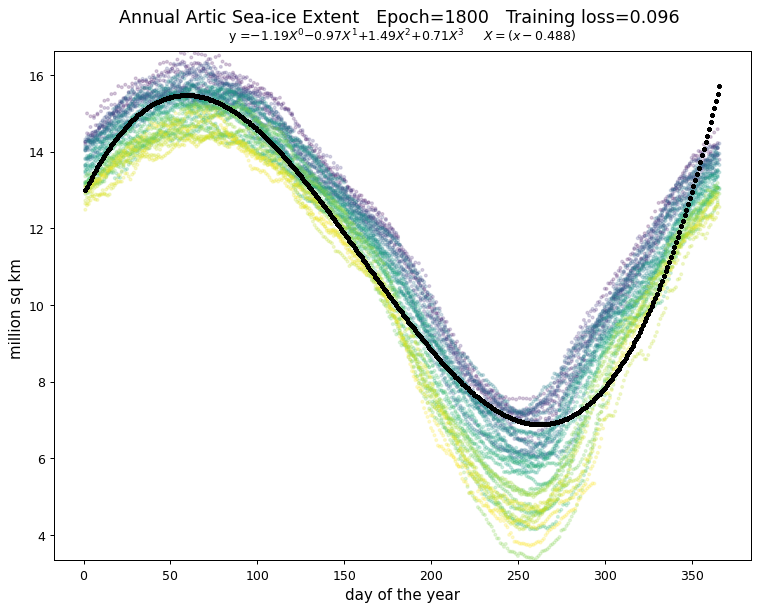

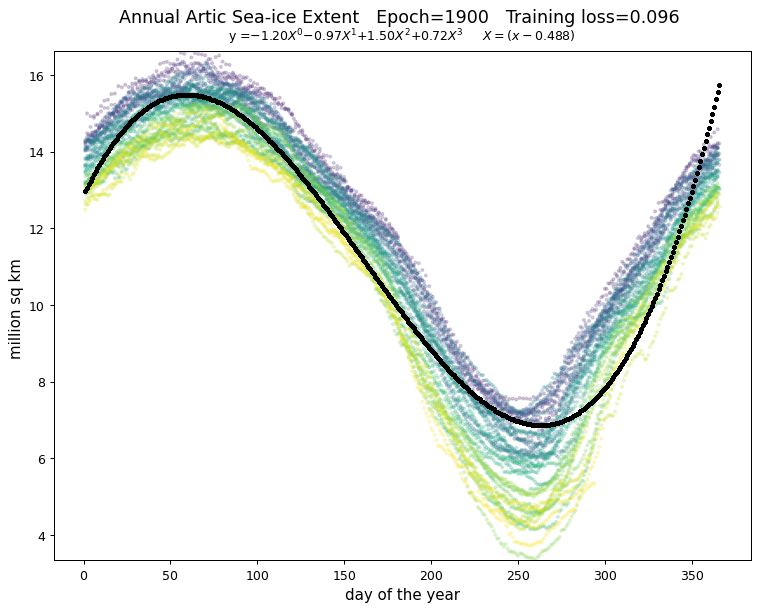

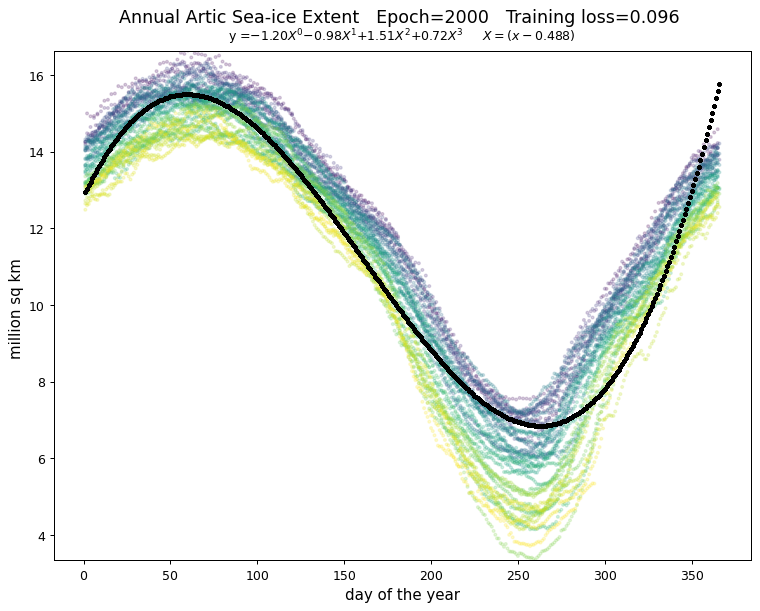

In [5]:
import torch
torch.manual_seed(0)

# DATA
x,y = load_data()

# MODEL
N  = 3 
x0 = torch.zeros(1,   requires_grad=True)
w  = torch.zeros(N+1, requires_grad=True)
def model(x): return sum( w[i]*(x-x0)**i for i in range(N+1) ) 

# CONFIGURE
optimizer = torch.optim.AdamW(params = [x0,w], lr=2e-3)
loss_fcn  = torch.nn.MSELoss()

for epoch in range(2000+1):

  # TRAIN
  prediction = model(x)
  optimizer.zero_grad()
  loss = loss_fcn(prediction, y)
  loss.backward()
  optimizer.step()

  with torch.no_grad(): plot(interval=100)


**Combine images into a video**

In [9]:
!ffmpeg -loglevel warning -i ./images/img_%04d.png -vf scale=1280:-2 -pix_fmt yuv420p -y out.mp4

**Display video in the notebook**

In [10]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('out.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

HTML("""
<video width=800 controls><source src="%s" type="video/mp4"></video>
""" % data_url)

In [ ]:
# remove images
!rm ./images/img_*.png